# Text Attack SKlearn Exploration

This notebook explores the text attack and text attack recipes primarily against sklearn models: logistic regression and random forests. Two vectorizers are used: one for TF-IDF and the other Bag of Words. The attacks present in the notebook are the ones that could be plausibly used against SkLearn. 5 attacks were successfully implemented. The chosen problem set is reviews from rotten tomatoes. The classification is to label positive or negative sentiment. 

## Importing

In [1]:
import datasets
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import *
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, SimpleRNN, Conv1D, MaxPool1D, Bidirectional,\
Dropout, MaxPooling1D, Activation
from tensorflow.keras.models import Model
import joblib
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

## Dataset

In [2]:
# Using rotten tomatos IMBD dataset for this
dataset = datasets.load_dataset('rotten_tomatoes')

Found cached dataset rotten_tomatoes (C:/Users/mattl/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

In [4]:
train_df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


## Preprocessing

In [5]:
#Function for preprocessing
def preprocess(row):

    row = re.sub('[%\n]', ' ', row)
    row = re.sub('[%’""-+\,.:<>-]', '', row)
    row = row.lstrip('[').rstrip(']')
    row = re.sub('[^A-Za-z0-9 ]+','',row)

    #lower case and remove white spaces
    row = row.lower()
    row = row.strip()

    #tokenize and remove stopwords
    tokens = tokenizer.tokenize(row)
    tokens = [w for w in tokens if w not in stop_words]
    lemma = [wnl.lemmatize(w) for w in tokens]
    return lemma

def rejoin_words(row):
    joined_words = ( " ".join(row))
    return joined_words

In [6]:
# Tokenize and remove stopwords
tokenizer = RegexpTokenizer(r'\w+')
# uncomment if need to download
#nltk.download("stopwords") 
#nltk.download('punkt')

stop_words =set(stopwords.words("english"))
wnl = nltk.stem.WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

for df in [train_df,test_df]:
    df['words'] = df['text'].apply(preprocess)
    df['processed'] = df['words'].apply(rejoin_words)

In [7]:
# For the purposes of this exercise just focus on TFidf for the word embedding
from sklearn.feature_extraction.text import TfidfVectorizer

#y = df['label'].values
#X = df.drop(['real'],axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

x_train = train_df['processed'].values.tolist()
x_test = test_df['processed'].values.tolist()
tfidf_vectorizer = TfidfVectorizer().fit(x_train)
x_train_matrix = tfidf_vectorizer.transform(x_train)
x_test_matrix = tfidf_vectorizer.transform(x_test)

words = tfidf_vectorizer.get_feature_names_out()
x_train_tfidf = pd.DataFrame(x_train_matrix.todense(), columns = words)
x_test_tfidf = pd.DataFrame(x_test_matrix.todense(), columns = words)

y_train = train_df['label'].values
y_test = test_df['label'].values

## Bag of Words

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
def get_bow(df):
    vectorizer = CountVectorizer()
    vect_fit = vectorizer.fit(df['processed'])
    bag_words = vect_fit.transform(df['processed'])
    df = pd.DataFrame(bag_words.toarray(), columns=vectorizer.get_feature_names_out())
    return df,vect_fit

## Logistic Regression Model

In [8]:
#find the optimal regularization parameter using GridSearchCV
params = {"C":[0.01,0.1,1,10]}
lg = LogisticRegression()

grid = GridSearchCV(lg, params)
grid.fit(x_train_tfidf, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'C': 10}
0.7479484173505275


In [10]:
# use the best parameters from gridserachCV
lg_grid = LogisticRegression(penalty='l2',C=10)
lg_grid.fit(x_train_tfidf,y_train)
lr_pred_tr = lg_grid.predict(x_train_tfidf)
lr_pred_te = lg_grid.predict(x_test_tfidf)
print("The roc_auc_score is:", roc_auc_score(y_test,lg_grid.predict_proba(x_test_tfidf)[:,1]))
print("The training accuracy is:",metrics.accuracy_score(y_train, lr_pred_tr))
print("The test accuracy is :", metrics.accuracy_score(y_test, lr_pred_te))

The roc_auc_score is: 0.8542287804174045
The training accuracy is: 0.9881594372801876
The test accuracy is : 0.7692307692307693


In [11]:
#additional bag of words model made
train_bow_df,bow_fit = get_bow(train_df)
# Bag of words cannot recognize words that are not in the training data
# For the purposes of this hackathon, just focus on the training accuracy.
#test_bow_df = get_bow(test_df)

In [62]:
#find the optimal regularization parameter using GridSearchCV
params = {"C":[0.01,0.1,1,10]}
bow_lg = LogisticRegression()

grid = GridSearchCV(bow_lg, params)
grid.fit(train_bow_df, y_train)

print(grid.best_params_)
print(grid.best_score_)

  0%|                                                                                           | 0/10 [27:57<?, ?it/s]


{'C': 1}
0.745369284876905


In [12]:
# use the best parameters from gridserachCV
bow_lg_grid = LogisticRegression(penalty='l2',C=1)
bow_lg_grid.fit(train_bow_df,y_train)
lr_pred_tr = lg_grid.predict(train_bow_df)
print("The training accuracy is:",metrics.accuracy_score(y_train, lr_pred_tr))

The training accuracy is: 0.9542790152403282


## Random Forest Model

### Code that takes a long time to run

In [17]:
#Gridsearch bag of words
params = {'n_estimators':[300,250,200,350],'max_depth':[None]}

rf_optimal_params = GridSearchCV(RandomForestClassifier(random_state=10), params)
rf_optimal_params.fit(x_train_tfidf, y_train)
rf_optimal_params.best_params_

{'max_depth': None, 'n_estimators': 300}

In [20]:
#Random Forest TF-IDF version. 
random_forest = RandomForestClassifier(random_state = 10, 
                                       max_depth = None,
                                       n_estimators = 300)
random_forest.fit(x_train_tfidf,y_train)
random_forest_tepred = random_forest.predict(x_test_tfidf)
print("Testing accuracy for random forest", metrics.accuracy_score(y_test,random_forest_tepred))
print("The roc_auc_score is:", roc_auc_score(y_test,random_forest.predict_proba(x_test_tfidf)[:,1]))
print(classification_report(y_test, random_forest_tepred))

Testing accuracy for random forest 0.724202626641651
The roc_auc_score is: 0.7977130406316331
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       533
           1       0.76      0.66      0.70       533

    accuracy                           0.72      1066
   macro avg       0.73      0.72      0.72      1066
weighted avg       0.73      0.72      0.72      1066



In [21]:
# Save the model to a file
model_filename = "random_forest_model.pkl"
joblib.dump(random_forest, model_filename)

['random_forest_model.pkl']

### Loading Random Forest Model above

In [13]:
# Load the Random Forest model from the saved file
rf_model = joblib.load("random_forest_model.pkl")

In [14]:
random_forest_tepred = rf_model.predict(x_test_tfidf)
print("Testing accuracy for random forest", metrics.accuracy_score(y_test,random_forest_tepred))
print("The roc_auc_score is:", roc_auc_score(y_test,rf_model.predict_proba(x_test_tfidf)[:,1]))
print(classification_report(y_test, random_forest_tepred))

Testing accuracy for random forest 0.724202626641651
The roc_auc_score is: 0.7977130406316331
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       533
           1       0.76      0.66      0.70       533

    accuracy                           0.72      1066
   macro avg       0.73      0.72      0.72      1066
weighted avg       0.73      0.72      0.72      1066



# Text Attack Attacks

In [15]:
#Function for repeated code
from textattack.models.wrappers import SklearnModelWrapper
from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes import TextFoolerJin2019
from textattack import Attacker

def do_attack(model_wrapper,attack_recipe,text_attack_data):
    attack = attack_recipe.build(model_wrapper)
    attacker = Attacker(attack,text_attack_data)
    attacker.attack_dataset()

## Quick Note

SkLearnModel wrapper used an outdated function so the code needs to be manually changed in the source package in order to get it to work.

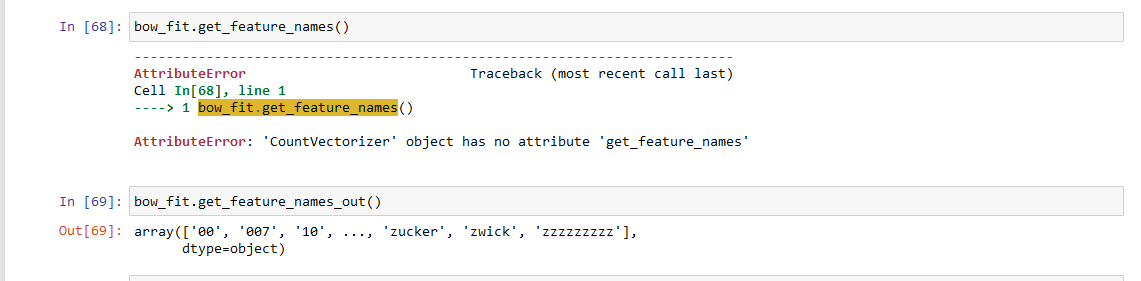

## TextFoolerJin2019

This attack recipe is a word based subsistution attack. It does so by subsituting words with a similar meaning. 

### Random Forest TF-IDF

In [16]:
rf_model_wrapper = SklearnModelWrapper(rf_model, tfidf_vectorizer)

In [17]:
text_attack_data = HuggingFaceDataset("rotten_tomatoes", None, "train")

Found cached dataset rotten_tomatoes (C:/Users/mattl/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

textattack: Loading datasets dataset rotten_tomatoes, split train.


In [18]:
do_attack(rf_model_wrapper,TextFoolerJin2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.ensemble._forest.RandomForestClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

 10%|████████▎                                                                          | 1/10 [00:09<01:22,  9.15s/it]

--------------------------------------------- Result 1 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|██▉                          | 1/10 [00:09<01:25,  9.46s/it]

[[Positive (74%)]] --> [[Negative (55%)]]

the rock is [[destined]] to be the 21st century's [[new]] " conan " and that he's going to make a splash even [[greater]] than arnold schwarzenegger , jean-claud van damme or [[steven]] [[segal]] .

the rock is [[intention]] to be the 21st century's [[newest]] " conan " and that he's going to make a splash even [[high]] than arnold schwarzenegger , jean-claud van damme or [[etienne]] [[adler]] .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|█████▊                       | 2/10 [00:10<00:42,  5.27s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (51%)]]

the gorgeously elaborate continuation of " the [[lord]] of the rings " [[trilogy]] is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded [[vision]] of j . r . r . tolkien's middle-earth .

the gorgeously elaborate continuation of " the [[seigneur]] of the rings " [[netherworld]] is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded [[brainchild]] of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|████████▋                    | 3/10 [00:10<00:25,  3.66s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (79%)]]

[[effective]] but too-tepid biopic

[[helpful]] but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|███████████▌                 | 4/10 [00:11<00:17,  2.87s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (55%)]]

if you sometimes like to go to the movies to have [[fun]] , wasabi is a good place to start .

if you sometimes like to go to the movies to have [[amuse]] , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|██████████████▌              | 5/10 [00:11<00:11,  2.38s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (54%)]]

emerges as something [[rare]] , an issue movie that's so honest and keenly observed that it doesn't feel like one .

emerges as something [[scarce]] , an issue movie that's so honest and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:13<00:09,  2.33s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (51%)]]

the film [[provides]] some great insight into the neurotic [[mindset]] of all comics -- even those who have [[reached]] the [[absolute]] [[top]] of the [[game]] .

the film [[constitutes]] some great insight into the neurotic [[philosophy]] of all comics -- even those who have [[made]] the [[utter]] [[alto]] of the [[jeu]] .




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:14<00:06,  2.06s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (72%)]]

offers that [[rare]] combination of entertainment and education .

offers that [[scant]] combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 8 / 0 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:15<00:01,  1.72s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (51%)]]

perhaps no [[picture]] ever made has more literally showed that the road to hell is paved with [[good]] intentions .

perhaps no [[photo]] ever made has more literally showed that the road to hell is paved with [[adequate]] intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (59%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 9 / 0 / 1 / 10: 100%|███████████████████████████| 10/10 [00:16<00:00,  1.62s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (60%)]]

take care of my cat offers a [[refreshingly]] different slice of asian [[cinema]] .

take care of my cat offers a [[divinely]] different slice of asian [[movie]] .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 13.83% |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 81.11  |
+-------------------------------+--------+


We can see that when under attack the tfidf model's training accuracy goes down to an astonishing 0%. 

### Bag of Words: TF-IDF and Bag of Words

In [19]:
lg_model_wrapper = SklearnModelWrapper(lg_grid, tfidf_vectorizer)

In [20]:
do_attack(lg_model_wrapper,TextFoolerJin2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|██▉                          | 1/10 [00:06<01:01,  6.78s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (64%)]]

the rock is [[destined]] to be the 21st century's new " conan " and that he's going to [[make]] a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .

the rock is [[meant]] to be the 21st century's new " conan " and that he's going to [[produce]] a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|█████▊                       | 2/10 [00:07<00:30,  3.80s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (62%)]]

the gorgeously elaborate continuation of " the [[lord]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded [[vision]] of j . r . r . tolkien's middle-earth .

the gorgeously elaborate continuation of " the [[god]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded [[thinking]] of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|████████▋                    | 3/10 [00:08<00:18,  2.67s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (51%)]]

[[effective]] but too-tepid biopic

[[helpful]] but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|███████████▌                 | 4/10 [00:08<00:12,  2.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (60%)]]

if you sometimes like to go to the movies to have [[fun]] , wasabi is a good place to start .

if you sometimes like to go to the movies to have [[joys]] , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|██████████████▌              | 5/10 [00:09<00:09,  1.82s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (60%)]]

emerges as something [[rare]] , an issue movie that's so [[honest]] and keenly observed that it doesn't feel like one .

emerges as something [[scant]] , an issue movie that's so [[honesty]] and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:09<00:06,  1.61s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (55%)]]

the film [[provides]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

the film [[gives]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:10<00:04,  1.46s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (95%)]] --> [[Negative (86%)]]

offers that [[rare]] combination of entertainment and [[education]] .

offers that [[scant]] combination of entertainment and [[school]] .




[Succeeded / Failed / Skipped / Total] 8 / 0 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:11<00:01,  1.25s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (61%)]]

perhaps no picture ever made has more literally [[showed]] that the [[road]] to hell is paved with good intentions .

perhaps no picture ever made has more literally [[shown]] that the [[track]] to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 9 / 0 / 1 / 10: 100%|███████████████████████████| 10/10 [00:12<00:00,  1.23s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (99%)]] --> [[Negative (74%)]]

take care of my cat offers a [[refreshingly]] [[different]] slice of asian [[cinema]] .

take care of my cat offers a [[splendidly]] [[disjointed]] slice of asian [[theater]] .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 12.9%  |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 75.56  |
+-------------------------------+--------+


Likewise, the attack words well on the logistic regression model. This model's accuracy also goes down to 0%. For the sake of completeness, let us explore a bag of words logistic regression model. RF is excluded due to lower accuracy and interpretability.

In [21]:
bow_lg_model_wrapper = SklearnModelWrapper(bow_lg_grid, bow_fit)

In [22]:
do_attack(bow_lg_model_wrapper,TextFoolerJin2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|██▉                          | 1/10 [00:06<01:00,  6.69s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (73%)]]

the rock is [[destined]] to be the 21st century's new " conan " and that he's going to [[make]] a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .

the rock is [[meant]] to be the 21st century's new " conan " and that he's going to [[produce]] a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|█████▊                       | 2/10 [00:07<00:29,  3.74s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (51%)]]

the gorgeously elaborate continuation of " the [[lord]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded [[vision]] of j . r . r . tolkien's middle-earth .

the gorgeously elaborate continuation of " the [[seigneur]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded [[idea]] of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|████████▋                    | 3/10 [00:07<00:18,  2.62s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (81%)]] --> [[[FAILED]]]

effective but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|███████████▌                 | 4/10 [00:08<00:12,  2.08s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (54%)]]

if you sometimes like to go to the movies to have [[fun]] , wasabi is a good place to start .

if you sometimes like to go to the movies to have [[amuse]] , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|██████████████▌              | 5/10 [00:08<00:08,  1.75s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (54%)]]

emerges as something [[rare]] , an issue movie that's so honest and keenly observed that it doesn't feel like one .

emerges as something [[scant]] , an issue movie that's so honest and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:09<00:06,  1.56s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (55%)]]

the film [[provides]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

the film [[gives]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:09<00:04,  1.42s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (75%)]]

offers that [[rare]] combination of entertainment and [[education]] .

offers that [[sometimes]] combination of entertainment and [[school]] .




[Succeeded / Failed / Skipped / Total] 7 / 1 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:10<00:01,  1.21s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (50%)]]

perhaps no picture ever made has more literally showed that the [[road]] to [[hell]] is paved with good intentions .

perhaps no picture ever made has more literally showed that the [[track]] to [[hellfire]] is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 8 / 1 / 1 / 10: 100%|███████████████████████████| 10/10 [00:11<00:00,  1.19s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (98%)]] --> [[Negative (73%)]]

take care of my cat offers a [[refreshingly]] [[different]] slice of asian [[cinema]] .

take care of my cat offers a [[splendidly]] [[disjointed]] slice of asian [[theater]] .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 88.89% |
| Average perturbed word %:     | 10.73% |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 67.67  |
+-------------------------------+--------+


We can see that the bag of words algorithim is more robust in this case but that is due to the TextFoolerJin2019 algorithm being unable to swap out words more than the model itself.

## Checklist (checklist_ribeiro_2020)

As per the documentation, this attack focuses on a number of attacks used in the Invariance Testing Method: Contraction, Extension, Changing Names, Number, Location.

### Random Forest TF-IDF

In [23]:
from textattack.attack_recipes import CheckList2020

In [24]:
do_attack(rf_model_wrapper,CheckList2020,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.ensemble._forest.RandomForestClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapExtend
    (1): WordSwapContract
    (2): WordSwapChangeName
    (3): WordSwapChangeNumber
    (4): WordSwapChangeLocation
    )
  (constraints): 
    (0): RepeatModification
  (is_black_box):  True
) 



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

2023-11-06 13:53:03,707 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|██▉                          | 1/10 [00:09<01:29,  9.90s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (74%)]] --> [[[FAILED]]]

the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|█████▊                       | 2/10 [00:13<00:53,  6.74s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (72%)]] --> [[[FAILED]]]

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|████████▋                    | 3/10 [00:13<00:32,  4.61s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (78%)]] --> [[[FAILED]]]

effective but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|███████████▌                 | 4/10 [00:14<00:21,  3.61s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (75%)]] --> [[[FAILED]]]

if you sometimes like to go to the movies to have fun , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|██████████████▌              | 5/10 [00:17<00:17,  3.47s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (64%)]] --> [[[FAILED]]]

emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:19<00:12,  3.17s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (90%)]] --> [[[FAILED]]]

the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:19<00:08,  2.79s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (83%)]] --> [[[FAILED]]]

offers that rare combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 0 / 8 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:20<00:02,  2.26s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (70%)]] --> [[[FAILED]]]

perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (59%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 0 / 9 / 1 / 10: 100%|███████████████████████████| 10/10 [00:20<00:00,  2.09s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (87%)]] --> [[[FAILED]]]

take care of my cat offers a refreshingly different slice of asian cinema .



+-------------------------------+-------+
| Attack Results                |       |
+-------------------------------+-------+
| Number of successful attacks: | 0     |
| Number of failed attacks:     | 9     |
| Number of skipped attacks:    | 1     |
| Original accuracy:            | 90.0% |
| Accuracy under attack:        | 90.0% |
| Attack success rate:          | 0.0%  |
| Average perturbed word %:     | nan%  |
| Average num. words per input: | 19.5  |
| Avg num queries:              | 6.56  |
+-------------------------------+-------+


### Bag of Words: TF-IDF and Bag of Words

In [25]:
do_attack(lg_model_wrapper,CheckList2020,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapExtend
    (1): WordSwapContract
    (2): WordSwapChangeName
    (3): WordSwapChangeNumber
    (4): WordSwapChangeLocation
    )
  (constraints): 
    (0): RepeatModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|██▉                          | 1/10 [00:04<00:43,  4.87s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (78%)]] --> [[[FAILED]]]

the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|█████▊                       | 2/10 [00:08<00:33,  4.19s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (81%)]] --> [[[FAILED]]]

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|████████▋                    | 3/10 [00:08<00:20,  2.91s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (88%)]] --> [[[FAILED]]]

effective but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|███████████▌                 | 4/10 [00:09<00:14,  2.34s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (68%)]] --> [[[FAILED]]]

if you sometimes like to go to the movies to have fun , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|██████████████▌              | 5/10 [00:12<00:12,  2.43s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (83%)]] --> [[[FAILED]]]

emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:13<00:09,  2.29s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (78%)]] --> [[[FAILED]]]

the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:14<00:06,  2.03s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (95%)]] --> [[[FAILED]]]

offers that rare combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 0 / 8 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:15<00:01,  1.67s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 0 / 9 / 1 / 10: 100%|███████████████████████████| 10/10 [00:15<00:00,  1.56s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (99%)]] --> [[[FAILED]]]

take care of my cat offers a refreshingly different slice of asian cinema .



+-------------------------------+-------+
| Attack Results                |       |
+-------------------------------+-------+
| Number of successful attacks: | 0     |
| Number of failed attacks:     | 9     |
| Number of skipped attacks:    | 1     |
| Original accuracy:            | 90.0% |
| Accuracy under attack:        | 90.0% |
| Attack success rate:          | 0.0%  |
| Average perturbed word %:     | nan%  |
| Average num. words per input: | 19.5  |
| Avg num queries:              | 5.44  |
+-------------------------------+-------+


In [26]:
do_attack(bow_lg_model_wrapper,CheckList2020,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapExtend
    (1): WordSwapContract
    (2): WordSwapChangeName
    (3): WordSwapChangeNumber
    (4): WordSwapChangeLocation
    )
  (constraints): 
    (0): RepeatModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|██▉                          | 1/10 [00:05<00:46,  5.21s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (84%)]] --> [[[FAILED]]]

the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|█████▊                       | 2/10 [00:08<00:35,  4.40s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (82%)]] --> [[[FAILED]]]

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|████████▋                    | 3/10 [00:09<00:21,  3.03s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (81%)]] --> [[[FAILED]]]

effective but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|███████████▌                 | 4/10 [00:09<00:14,  2.42s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (57%)]] --> [[[FAILED]]]

if you sometimes like to go to the movies to have fun , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|██████████████▌              | 5/10 [00:12<00:12,  2.48s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (78%)]] --> [[[FAILED]]]

emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:14<00:09,  2.35s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (81%)]] --> [[[FAILED]]]

the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:14<00:06,  2.08s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (88%)]] --> [[[FAILED]]]

offers that rare combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 0 / 8 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:15<00:01,  1.70s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 0 / 9 / 1 / 10: 100%|███████████████████████████| 10/10 [00:15<00:00,  1.58s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (98%)]] --> [[[FAILED]]]

take care of my cat offers a refreshingly different slice of asian cinema .



+-------------------------------+-------+
| Attack Results                |       |
+-------------------------------+-------+
| Number of successful attacks: | 0     |
| Number of failed attacks:     | 9     |
| Number of skipped attacks:    | 1     |
| Original accuracy:            | 90.0% |
| Accuracy under attack:        | 90.0% |
| Attack success rate:          | 0.0%  |
| Average perturbed word %:     | nan%  |
| Average num. words per input: | 19.5  |
| Avg num queries:              | 5.44  |
+-------------------------------+-------+


We can see that this attack method is unable to attack this model effectively. 

## CLARE (clare_li_2020) - Not Working

This algorithim constructs adversarial examples to test the robustness of NLP Models

### Random Forest TF-IDF

In [27]:
from textattack.attack_recipes import CLARE2020

In [28]:
do_attack(rf_model_wrapper,CLARE2020,text_attack_data)

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`


textattack: Unknown if model of class <class 'sklearn.ensemble._forest.RandomForestClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapMaskedLM(
        (method):  bae
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.0005
      )
    (1): WordInsertionMaskedLM(
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.0
      )
    (2): WordMergeMaskedLM(
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.005
      )
    )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.7
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

KeyError: 'upos'

### Bag of Words: TF-IDF and Bag of Words

In [29]:
do_attack(lg_model_wrapper,CLARE2020,text_attack_data)

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapMaskedLM(
        (method):  bae
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.0005
      )
    (1): WordInsertionMaskedLM(
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.0
      )
    (2): WordMergeMaskedLM(
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.005
      )
    )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.7
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

KeyError: 'upos'

In [30]:
do_attack(bow_lg_model_wrapper,CLARE2020,text_attack_data)

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapMaskedLM(
        (method):  bae
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.0005
      )
    (1): WordInsertionMaskedLM(
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.0
      )
    (2): WordMergeMaskedLM(
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.005
      )
    )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.7
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





  0%|                                                                                           | 0/10 [01:57<?, ?it/s]


KeyError: 'upos'

This attack appears to not work against sklearn models

## Faster Alzantot Genetic Algorithm (faster_genetic_algorithm_jia_2019) - Not Working

This Algorithm implements an optimization algorithm inspired by the proccess of natural selection.

### Random Forest TF-IDF

In [32]:
from textattack.attack_recipes import FasterGeneticAlgorithmJia2019

In [35]:
do_attack(rf_model_wrapper,FasterGeneticAlgorithmJia2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.ensemble._forest.RandomForestClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): AlzantotGeneticAlgorithm(
    (pop_size):  60
    (max_iters):  40
    (temp):  0.3
    (give_up_if_no_improvement):  False
    (post_crossover_check):  False
    (max_crossover_retries):  20
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  8
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (1): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (max_mse_dist):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (2): LearningToWriteLanguageModel(
        (max_log_prob_diff):  5.0
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

IndexError: index is out of bounds for dimension with size 0

### Bag of Words: TF-IDF and Bag of Words

In [43]:
do_attack(lg_model_wrapper,FasterGeneticAlgorithmJia2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): AlzantotGeneticAlgorithm(
    (pop_size):  60
    (max_iters):  40
    (temp):  0.3
    (give_up_if_no_improvement):  False
    (post_crossover_check):  False
    (max_crossover_retries):  20
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  8
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (1): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (max_mse_dist):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (2): LearningToWriteLanguageModel(
        (max_log_prob_diff):  5.0
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

IndexError: index is out of bounds for dimension with size 0

In [36]:
do_attack(bow_lg_model_wrapper,FasterGeneticAlgorithmJia2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): AlzantotGeneticAlgorithm(
    (pop_size):  60
    (max_iters):  40
    (temp):  0.3
    (give_up_if_no_improvement):  False
    (post_crossover_check):  False
    (max_crossover_retries):  20
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  8
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (1): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (max_mse_dist):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (2): LearningToWriteLanguageModel(
        (max_log_prob_diff):  5.0
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 






  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

IndexError: index is out of bounds for dimension with size 0

This one does not work with SKLearn and as a result, the slower version most likely does not either.

## Hotflip (hotflip_ebrahimi_2017) - Not Working

This method of attack focuses on changing characters in the input text. 

### Random Forest TF-IDF

In [38]:
from textattack.attack_recipes import HotFlipEbrahimi2017

In [39]:
do_attack(rf_model_wrapper,HotFlipEbrahimi2017,text_attack_data)

ValueError: Cannot perform GradientBasedWordSwap on model RandomForestClassifier(n_estimators=300, random_state=10).

### Bag of Words: TF-IDF and Bag of Words

In [41]:
do_attack(lg_model_wrapper,HotFlipEbrahimi2017,text_attack_data)

ValueError: Cannot perform GradientBasedWordSwap on model LogisticRegression(C=10).

In [42]:
do_attack(bow_lg_model_wrapper,HotFlipEbrahimi2017,text_attack_data)

ValueError: Cannot perform GradientBasedWordSwap on model LogisticRegression(C=1).

## IGA (iga_wang_2019)

This is an improved genetic algorithim. It also poisons the input to cause training accuracy deficiency.

### Random Forest TF-IDF

In [27]:
from textattack.attack_recipes import IGAWang2019

In [28]:
do_attack(rf_model_wrapper,IGAWang2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.ensemble._forest.RandomForestClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): ImprovedGeneticAlgorithm(
    (pop_size):  60
    (max_iters):  20
    (temp):  0.3
    (give_up_if_no_improvement):  False
    (post_crossover_check):  False
    (max_crossover_retries):  20
    (max_replace_times_per_index):  5
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (1): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (max_mse_dist):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  False
      )
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|██▉                          | 1/10 [00:17<02:34, 17.16s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (74%)]] --> [[Negative (52%)]]

the rock is [[destined]] to be the 21st century's new " conan " and that he's [[going]] to [[make]] a splash even greater than arnold schwarzenegger , jean-claud van damme or [[steven]] segal .

the rock is [[designed]] to be the 21st century's new " conan " and that he's [[gonna]] to [[render]] a splash even greater than arnold schwarzenegger , jean-claud van damme or [[stevens]] segal .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|█████▊                       | 2/10 [00:27<01:49, 13.65s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (72%)]] --> [[Negative (51%)]]

the gorgeously elaborate continuation of " the [[lord]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded [[vision]] of j . r . r . tolkien's middle-earth .

the gorgeously elaborate continuation of " the [[god]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded [[eyesight]] of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|████████▋                    | 3/10 [00:27<01:04,  9.19s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (79%)]]

[[effective]] but too-tepid biopic

[[potency]] but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|███████████▌                 | 4/10 [00:29<00:44,  7.46s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (57%)]]

if you sometimes like to go to the movies to have [[fun]] , wasabi is a good place to start .

if you sometimes like to go to the movies to have [[pleasurable]] , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|██████████████▌              | 5/10 [00:31<00:31,  6.38s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (54%)]]

emerges as something [[rare]] , an issue movie that's so honest and keenly observed that it doesn't feel like one .

emerges as something [[few]] , an issue movie that's so honest and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:40<00:27,  6.82s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (90%)]] --> [[Negative (50%)]]

the film [[provides]] some [[great]] insight into the neurotic mindset of all comics -- even those who have reached the absolute [[top]] of the game .

the film [[affords]] some [[noteworthy]] insight into the neurotic mindset of all comics -- even those who have reached the absolute [[superior]] of the game .




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:41<00:17,  5.98s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (71%)]]

offers that [[rare]] combination of entertainment and education .

offers that [[rarity]] combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 8 / 0 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:43<00:04,  4.88s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (50%)]]

perhaps no picture [[ever]] made has more literally showed that the road to hell is paved with good intentions .

perhaps no picture [[perpetually]] made has more literally showed that the road to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (59%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 9 / 0 / 1 / 10: 100%|███████████████████████████| 10/10 [00:53<00:00,  5.34s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (87%)]] --> [[Negative (50%)]]

take care of my cat offers a refreshingly [[different]] [[slice]] of asian [[cinema]] .

take care of my cat offers a refreshingly [[numerous]] [[chopping]] of asian [[movie]] .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 12.01% |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 385.56 |
+-------------------------------+--------+


### Bag of Words: TF-IDF and Bag of Words

In [29]:
do_attack(lg_model_wrapper,IGAWang2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): ImprovedGeneticAlgorithm(
    (pop_size):  60
    (max_iters):  20
    (temp):  0.3
    (give_up_if_no_improvement):  False
    (post_crossover_check):  False
    (max_crossover_retries):  20
    (max_replace_times_per_index):  5
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (1): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (max_mse_dist):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  False
      )
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|██▉                          | 1/10 [00:13<01:59, 13.33s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (60%)]]

the rock is [[destined]] to be the 21st century's new " conan " and that he's going to make a splash even [[greater]] than arnold schwarzenegger , jean-claud van damme or [[steven]] segal .

the rock is [[meant]] to be the 21st century's new " conan " and that he's going to make a splash even [[stronger]] than arnold schwarzenegger , jean-claud van damme or [[stephen]] segal .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|█████▊                       | 2/10 [00:24<01:37, 12.14s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (50%)]]

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot [[adequately]] describe co-writer/director peter jackson's expanded [[vision]] of j . r . r . tolkien's middle-earth .

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot [[sufficient]] describe co-writer/director peter jackson's expanded [[conception]] of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|████████▋                    | 3/10 [00:24<00:57,  8.18s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (63%)]]

[[effective]] but too-tepid biopic

[[potency]] but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|███████████▌                 | 4/10 [00:26<00:39,  6.60s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (60%)]]

if you sometimes like to go to the movies to have [[fun]] , wasabi is a good place to start .

if you sometimes like to go to the movies to have [[amusing]] , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|██████████████▌              | 5/10 [00:30<00:30,  6.14s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (81%)]]

emerges as [[something]] [[rare]] , an issue movie that's so honest and [[keenly]] observed that it doesn't feel like one .

emerges as [[nothing]] [[few]] , an issue movie that's so honest and [[passionately]] observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:34<00:22,  5.72s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (57%)]]

the film [[provides]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

the film [[provide]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:36<00:15,  5.28s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (95%)]] --> [[Negative (82%)]]

offers that [[rare]] combination of entertainment and [[education]] .

offers that [[few]] combination of entertainment and [[school]] .




[Succeeded / Failed / Skipped / Total] 8 / 0 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:40<00:04,  4.53s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (57%)]]

perhaps no picture [[ever]] made has more literally [[showed]] that the road to hell is paved with [[good]] intentions .

perhaps no picture [[increasingly]] made has more literally [[shown]] that the road to hell is paved with [[decent]] intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 9 / 0 / 1 / 10: 100%|███████████████████████████| 10/10 [00:55<00:00,  5.58s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (99%)]] --> [[Negative (58%)]]

take care of my [[cat]] offers a refreshingly [[different]] [[slice]] of asian [[cinema]] .

take care of my [[cats]] offers a refreshingly [[various]] [[cutout]] of asian [[theater]] .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 15.3%  |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 557.78 |
+-------------------------------+--------+


In [30]:
do_attack(bow_lg_model_wrapper,IGAWang2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): ImprovedGeneticAlgorithm(
    (pop_size):  60
    (max_iters):  20
    (temp):  0.3
    (give_up_if_no_improvement):  False
    (post_crossover_check):  False
    (max_crossover_retries):  20
    (max_replace_times_per_index):  5
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (1): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (max_mse_dist):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  False
      )
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|██▉                          | 1/10 [00:14<02:07, 14.14s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (84%)]] --> [[Negative (58%)]]

the rock is [[destined]] to be the 21st century's new " conan " and that he's going to [[make]] a splash even greater than arnold schwarzenegger , jean-claud van damme or [[steven]] segal .

the rock is [[meant]] to be the 21st century's new " conan " and that he's going to [[render]] a splash even greater than arnold schwarzenegger , jean-claud van damme or [[stephen]] segal .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|█████▊                       | 2/10 [00:21<01:25, 10.66s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (51%)]]

the gorgeously elaborate continuation of " the [[lord]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .

the gorgeously elaborate continuation of " the [[god]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|████████▋                    | 3/10 [00:21<00:50,  7.21s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (54%)]]

[[effective]] but too-tepid biopic

[[potency]] but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|███████████▌                 | 4/10 [00:24<00:36,  6.07s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (71%)]]

if you sometimes like to go to the movies to have [[fun]] , wasabi is a good place to start .

if you sometimes like to go to the movies to have [[amusing]] , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|██████████████▌              | 5/10 [00:31<00:31,  6.22s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (79%)]]

[[emerges]] as something [[rare]] , an issue movie that's so honest and keenly [[observed]] that it doesn't feel like one .

[[appear]] as something [[few]] , an issue movie that's so honest and keenly [[saw]] that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:35<00:23,  5.86s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (59%)]]

the film [[provides]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

the film [[provide]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:36<00:15,  5.24s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (50%)]]

offers that [[rare]] [[combination]] of entertainment and education .

offers that [[few]] [[mixing]] of entertainment and education .




[Succeeded / Failed / Skipped / Total] 8 / 0 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:40<00:04,  4.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (86%)]] --> [[Negative (60%)]]

perhaps no picture ever made has more literally [[showed]] that the road to hell is paved with good [[intentions]] .

perhaps no picture ever made has more literally [[shown]] that the road to hell is paved with good [[intention]] .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 9 / 0 / 1 / 10: 100%|███████████████████████████| 10/10 [00:55<00:00,  5.56s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (98%)]] --> [[Negative (62%)]]

[[take]] [[care]] of my [[cat]] offers a [[refreshingly]] different slice of asian [[cinema]] .

[[taking]] [[caring]] of my [[cats]] offers a [[joyfully]] different slice of asian [[theater]] .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 15.24% |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 588.33 |
+-------------------------------+--------+


## Kuleshov2017

This is an algorithim designed to generate adversial examples to poison the dataset.

### Random Forest TF-IDF

In [31]:
from textattack.attack_recipes import Kuleshov2017

In [32]:
do_attack(rf_model_wrapper,Kuleshov2017,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.ensemble._forest.RandomForestClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.5
        (compare_against_original):  True
      )
    (1): ThoughtVector(
        (word_embedding):  WordEmbedding
        (metric):  max_euclidean
        (threshold):  -0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): GPT2(
        (max_log_prob_diff):  2.0
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|██▉                          | 1/10 [00:15<02:16, 15.14s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (74%)]] --> [[Positive (62%)]]

the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold [[schwarzenegger]] , jean-claud van damme or steven segal .

the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold [[arnold]] , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|█████▊                       | 2/10 [00:32<02:10, 16.29s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (72%)]] --> [[Positive (53%)]]

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded [[vision]] of j . r . r . tolkien's middle-earth .

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded [[conceptions]] of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|████████▋                    | 3/10 [00:32<01:16, 10.96s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (79%)]]

[[effective]] but too-tepid biopic

[[potency]] but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 4 / 0 / 1 / 5:  50%|██████████████▌              | 5/10 [00:39<00:39,  7.99s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (75%)]] --> [[Negative (58%)]]

if you sometimes like to go to the movies to have [[fun]] , wasabi is a good place to start .

if you sometimes like to go to the movies to have [[amusement]] , wasabi is a good place to start .


--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (64%)]] --> [[[SKIPPED]]]

emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 5 / 0 / 1 / 6:  60%|█████████████████▍           | 6/10 [00:49<00:32,  8.19s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (90%)]] --> [[Positive (65%)]]

the [[film]] provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

the [[movie]] provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 6 / 0 / 1 / 7:  70%|████████████████████▎        | 7/10 [00:52<00:22,  7.48s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (72%)]]

offers that [[rare]] combination of entertainment and education .

offers that [[meager]] combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 7 / 0 / 2 / 9:  90%|██████████████████████████   | 9/10 [01:01<00:06,  6.79s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (70%)]] --> [[Negative (74%)]]

perhaps no picture [[ever]] made has more literally showed that the road to hell is paved with good intentions .

perhaps no picture [[already]] made has more literally showed that the road to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (59%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 8 / 0 / 2 / 10: 100%|███████████████████████████| 10/10 [01:07<00:00,  6.72s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (87%)]] --> [[Positive (58%)]]

take care of my cat offers a refreshingly different slice of asian [[cinema]] .

take care of my cat offers a refreshingly different slice of asian [[movie]] .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 2      |
| Original accuracy:            | 80.0%  |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 8.27%  |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 113.88 |
+-------------------------------+--------+


### Bag of Words: TF-IDF and Bag of Words

In [33]:
do_attack(lg_model_wrapper,Kuleshov2017,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.5
        (compare_against_original):  True
      )
    (1): ThoughtVector(
        (word_embedding):  WordEmbedding
        (metric):  max_euclidean
        (threshold):  -0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): GPT2(
        (max_log_prob_diff):  2.0
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|██▉                          | 1/10 [00:14<02:06, 14.11s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (78%)]] --> [[Positive (59%)]]

the rock is [[destined]] to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .

the rock is [[meant]] to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|█████▊                       | 2/10 [00:30<02:00, 15.11s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (81%)]] --> [[Positive (59%)]]

the gorgeously elaborate continuation of " the [[lord]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .

the gorgeously elaborate continuation of " the [[god]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 3 / 0 / 1 / 4:  40%|███████████▌                 | 4/10 [00:30<00:45,  7.66s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (88%)]] --> [[Negative (63%)]]

[[effective]] but too-tepid biopic

[[potency]] but too-tepid biopic


--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (68%)]] --> [[[SKIPPED]]]

if you sometimes like to go to the movies to have fun , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 4 / 0 / 1 / 5:  50%|██████████████▌              | 5/10 [00:38<00:38,  7.69s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (50%)]]

emerges as something rare , an issue movie that's so honest and keenly [[observed]] that it doesn't feel like one .

emerges as something rare , an issue movie that's so honest and keenly [[followed]] that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 5 / 0 / 1 / 6:  60%|█████████████████▍           | 6/10 [00:47<00:31,  7.96s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (57%)]]

the film [[provides]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

the film [[offered]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 6 / 0 / 1 / 7:  70%|████████████████████▎        | 7/10 [00:50<00:21,  7.24s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (95%)]] --> [[Positive (63%)]]

offers that [[rare]] combination of entertainment and education .

offers that [[scant]] combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 7 / 0 / 2 / 9:  90%|██████████████████████████   | 9/10 [00:58<00:06,  6.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (86%)]] --> [[Positive (55%)]]

perhaps no picture [[ever]] made has more literally showed that the road to hell is paved with good intentions .

perhaps no picture [[already]] made has more literally showed that the road to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 8 / 0 / 2 / 10: 100%|███████████████████████████| 10/10 [01:09<00:00,  6.92s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (99%)]] --> [[Positive (58%)]]

take care of my cat offers a refreshingly different [[slice]] of asian [[cinema]] .

take care of my cat offers a refreshingly different [[portion]] of asian [[theater]] .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 2      |
| Original accuracy:            | 80.0%  |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 9.23%  |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 128.88 |
+-------------------------------+--------+


In [34]:
do_attack(bow_lg_model_wrapper,Kuleshov2017,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.5
        (compare_against_original):  True
      )
    (1): ThoughtVector(
        (word_embedding):  WordEmbedding
        (metric):  max_euclidean
        (threshold):  -0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): GPT2(
        (max_log_prob_diff):  2.0
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|██▉                          | 1/10 [00:14<02:07, 14.12s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (84%)]] --> [[Positive (60%)]]

the rock is [[destined]] to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .

the rock is [[meant]] to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|█████▊                       | 2/10 [00:30<02:02, 15.28s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (82%)]] --> [[Negative (51%)]]

the gorgeously elaborate continuation of " the [[lord]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .

the gorgeously elaborate continuation of " the [[god]] of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 3 / 0 / 1 / 4:  40%|███████████▌                 | 4/10 [00:30<00:46,  7.74s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (54%)]]

[[effective]] but too-tepid biopic

[[potency]] but too-tepid biopic


--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (57%)]] --> [[[SKIPPED]]]

if you sometimes like to go to the movies to have fun , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 4 / 0 / 1 / 5:  50%|██████████████▌              | 5/10 [00:38<00:38,  7.77s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (55%)]]

emerges as something rare , an issue movie that's so [[honest]] and keenly observed that it doesn't feel like one .

emerges as something rare , an issue movie that's so [[frank]] and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 5 / 0 / 1 / 6:  60%|█████████████████▍           | 6/10 [00:48<00:32,  8.05s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (59%)]]

the film [[provides]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

the film [[provide]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 6 / 0 / 1 / 7:  70%|████████████████████▎        | 7/10 [00:51<00:21,  7.32s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (88%)]] --> [[Positive (62%)]]

offers that [[rare]] combination of entertainment and education .

offers that [[scant]] combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 7 / 0 / 2 / 9:  90%|██████████████████████████   | 9/10 [00:58<00:06,  6.55s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (86%)]] --> [[Positive (52%)]]

perhaps no picture [[ever]] made has more literally showed that the road to hell is paved with good intentions .

perhaps no picture [[already]] made has more literally showed that the road to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 8 / 0 / 2 / 10: 100%|███████████████████████████| 10/10 [01:09<00:00,  6.99s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (98%)]] --> [[Positive (54%)]]

take care of my cat offers a [[refreshingly]] different slice of asian [[cinema]] .

take care of my cat offers a [[elegantly]] different slice of asian [[theater]] .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 2      |
| Original accuracy:            | 80.0%  |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 9.23%  |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 128.88 |
+-------------------------------+--------+


## Pruthi2019

This is an algorithim that swaps characters either by inserting or deleting them. It targets characters that are on adjacent keys on a QWERTY keyboard. 

### Random Forest TF-IDF

In [35]:
from textattack.attack_recipes import Pruthi2019

In [36]:
do_attack(rf_model_wrapper,Pruthi2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.ensemble._forest.RandomForestClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  False
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  False
      )
    (2): WordSwapRandomCharacterInsertion(
        (random_one):  False
      )
    (3): WordSwapQWERTY
    )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_num_words):  1
        (compare_against_original):  True
      )
    (1): MinWordLength
    (2): StopwordModification
    (3): RepeatModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|██▉                          | 1/10 [00:03<00:27,  3.09s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (74%)]] --> [[[FAILED]]]

the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|█████▊                       | 2/10 [00:08<00:32,  4.02s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (72%)]] --> [[[FAILED]]]

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  30%|████████▋                    | 3/10 [00:08<00:20,  2.94s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (78%)]]

[[effective]] but too-tepid biopic

[[eSffective]] but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:  40%|███████████▌                 | 4/10 [00:09<00:14,  2.46s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (75%)]] --> [[[FAILED]]]

if you sometimes like to go to the movies to have fun , wasabi is a good place to start .




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:  50%|██████████████▌              | 5/10 [00:11<00:11,  2.30s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (64%)]] --> [[Negative (54%)]]

emerges as something [[rare]] , an issue movie that's so honest and keenly observed that it doesn't feel like one .

emerges as something [[rEare]] , an issue movie that's so honest and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:13<00:09,  2.28s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (90%)]] --> [[[FAILED]]]

the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 3 / 4 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:14<00:06,  2.14s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (83%)]] --> [[Negative (71%)]]

offers that [[rare]] combination of entertainment and education .

offers that [[rae]] combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 3 / 5 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:16<00:01,  1.87s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (70%)]] --> [[[FAILED]]]

perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (59%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 3 / 6 / 1 / 10: 100%|███████████████████████████| 10/10 [00:18<00:00,  1.83s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (87%)]] --> [[[FAILED]]]

take care of my cat offers a refreshingly different slice of asian cinema .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 3      |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 60.0%  |
| Attack success rate:          | 33.33% |
| Average perturbed word %:     | 14.25% |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 353.89 |
+-------------------------------+--------+


### Bag of Words: TF-IDF and Bag of Words

In [37]:
do_attack(lg_model_wrapper,Pruthi2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  False
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  False
      )
    (2): WordSwapRandomCharacterInsertion(
        (random_one):  False
      )
    (3): WordSwapQWERTY
    )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_num_words):  1
        (compare_against_original):  True
      )
    (1): MinWordLength
    (2): StopwordModification
    (3): RepeatModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|██▉                          | 1/10 [00:02<00:24,  2.71s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (78%)]] --> [[[FAILED]]]

the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|█████▊                       | 2/10 [00:06<00:27,  3.49s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (81%)]] --> [[[FAILED]]]

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|████████▋                    | 3/10 [00:07<00:17,  2.54s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (88%)]] --> [[[FAILED]]]

effective but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:  40%|███████████▌                 | 4/10 [00:08<00:12,  2.14s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (68%)]] --> [[Negative (81%)]]

if you sometimes like to go to the movies to have fun , wasabi is a [[good]] place to start .

if you sometimes like to go to the movies to have fun , wasabi is a [[god]] place to start .




[Succeeded / Failed / Skipped / Total] 1 / 4 / 0 / 5:  50%|██████████████▌              | 5/10 [00:10<00:10,  2.03s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (83%)]] --> [[[FAILED]]]

emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:11<00:07,  1.98s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (55%)]]

the film [[provides]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

the film [[pMrovides]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:13<00:05,  1.87s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (95%)]] --> [[[FAILED]]]

offers that rare combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 2 / 6 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:14<00:01,  1.64s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 2 / 7 / 1 / 10: 100%|███████████████████████████| 10/10 [00:16<00:00,  1.62s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (99%)]] --> [[[FAILED]]]

take care of my cat offers a refreshingly different slice of asian cinema .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 2      |
| Number of failed attacks:     | 7      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 70.0%  |
| Attack success rate:          | 22.22% |
| Average perturbed word %:     | 4.71%  |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 353.89 |
+-------------------------------+--------+


In [38]:
do_attack(bow_lg_model_wrapper,Pruthi2019,text_attack_data)

textattack: Unknown if model of class <class 'sklearn.linear_model._logistic.LogisticRegression'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  False
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  False
      )
    (2): WordSwapRandomCharacterInsertion(
        (random_one):  False
      )
    (3): WordSwapQWERTY
    )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_num_words):  1
        (compare_against_original):  True
      )
    (1): MinWordLength
    (2): StopwordModification
    (3): RepeatModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|██▉                          | 1/10 [00:02<00:24,  2.76s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Positive (84%)]] --> [[[FAILED]]]

the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|█████▊                       | 2/10 [00:07<00:28,  3.54s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Positive (82%)]] --> [[[FAILED]]]

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|████████▋                    | 3/10 [00:07<00:18,  2.57s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Positive (81%)]] --> [[[FAILED]]]

effective but too-tepid biopic




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:  40%|███████████▌                 | 4/10 [00:08<00:12,  2.17s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Positive (57%)]] --> [[Negative (83%)]]

if you sometimes like to go to the movies to have fun , wasabi is a [[good]] place to start .

if you sometimes like to go to the movies to have fun , wasabi is a [[god]] place to start .




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:  50%|██████████████▌              | 5/10 [00:10<00:10,  2.04s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Positive (78%)]] --> [[Negative (56%)]]

emerges as something [[rare]] , an issue movie that's so honest and keenly observed that it doesn't feel like one .

emerges as something [[rate]] , an issue movie that's so honest and keenly observed that it doesn't feel like one .




[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:  60%|█████████████████▍           | 6/10 [00:11<00:07,  2.00s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (81%)]] --> [[Negative (55%)]]

the film [[provides]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

the film [[pdovides]] some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .




[Succeeded / Failed / Skipped / Total] 3 / 4 / 0 / 7:  70%|████████████████████▎        | 7/10 [00:13<00:05,  1.88s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (88%)]] --> [[[FAILED]]]

offers that rare combination of entertainment and education .




[Succeeded / Failed / Skipped / Total] 3 / 5 / 1 / 9:  90%|██████████████████████████   | 9/10 [00:14<00:01,  1.66s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (86%)]] --> [[[FAILED]]]

perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .


--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (54%)]] --> [[[SKIPPED]]]

steers turns in a snappy screenplay that curls at the edges ; it's so clever you want to hate it . but he somehow pulls it off .




[Succeeded / Failed / Skipped / Total] 3 / 6 / 1 / 10: 100%|███████████████████████████| 10/10 [00:16<00:00,  1.63s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Positive (98%)]] --> [[[FAILED]]]

take care of my cat offers a refreshingly different slice of asian cinema .



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 3      |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 60.0%  |
| Attack success rate:          | 33.33% |
| Average perturbed word %:     | 4.9%   |
| Average num. words per input: | 19.5   |
| Avg num queries:              | 353.89 |
+-------------------------------+--------+


It does not appear to be particularly effective as opposed to the other algorithims.

## Summary:

Most of these attacks are aimed at neural networks specifically. However, there are some algorithims that can target SKlearn models. In order of most effective to least effective these models are the following:
1. IGA (iga_wang_2019)
2. TextFoolerJin2019
3. Kuleshov2017
4. Pruthi2019
5. Checklist
